# **P3 - Transcriptómica II 2025**

## **A: Cell type classification using an integrated reference**

This Google Colab notebook (R) demonstrates how cell label transfer works with Seurat. We are starting with two seurat objects: one PMBCs sample with 3000 cells and other PBMCs sample with 10000 cells, annotated and which will be used as the reference dataset. More details at Seurat's [vignette](https://satijalab.org/seurat/articles/integration_mapping.html). Once generated, the reference can be used to analyze additional query datasets through tasks like cell type label transfer and projecting query cells onto reference UMAPs. Notably, this does not require correction of the underlying raw query data and can therefore be an efficient strategy if a high quality reference is available.



Seurat supports the projection of reference data (or meta data) onto a query object. While many of the methods are conserved (both procedures begin by identifying anchors), there are two important distinctions between data transfer and integration:

1. In data transfer, Seurat does not correct or modify the query expression data.
2. In data transfer, Seurat has an option (set by default) to project the PCA structure of a reference onto the query, instead of learning a joint structure with CCA. We generally suggest using this option when projecting data between scRNA-seq datasets.

After finding anchors, we use the `TransferData()` function to classify the query cells based on reference data (a vector of reference cell type labels). `TransferData()` returns a matrix with predicted IDs and prediction scores, which we can add to the query metadata

**1. Install packages**

In [ ]:
install.packages("Seurat", quietly=TRUE)

In [ ]:
## Bioconductor

if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("glmGamPoi", quietly=TRUE, ask=FALSE, update=FALSE)

In [ ]:
system("pip3 install leidenalg")

In [ ]:
install.packages("harmony")

In [ ]:
library(tidyverse) #preinstalled in Google Colab
library(Seurat)
library(patchwork)

In [ ]:
#added to make the axis labels and titles and legend titles larger in Google Colab
theme(axis.text = element_text(size = 12),
      axis.title = element_text(size = 14),
      legend.title = element_text(size = 14))

**2. Load Seurat objects**

First, we load and inspect the reference and query dataset. The reference dataset already has a UMAP and clusters and cell type annotations. The query is the seurat object we generated in the first practical session.

In [ ]:
#Read in the PBMCs reference object and inspect it
#reference
ref10k.seu <- readRDS("P3/pbmc_10k_v3.rds")
ref10k.seu <- UpdateSeuratObject(ref10k.seu)

In [ ]:
ref10k.seu

In [ ]:
head(ref10k.seu@meta.data,2)

In [ ]:
table(ref10k.seu$celltype)

In [ ]:
 DimPlot(ref10k.seu, reduction = "umap", group.by = "celltype", label = TRUE, label.size = 3,
    repel = TRUE) + NoLegend() + ggtitle("Reference annotations")


Now we load our query dataset (from the first practical session).

In [ ]:
query3k.seu <- readRDS("P3/seu_full.rds")
query3k.seu

In [ ]:
DimPlot(query3k.seu, reduction = "umap", split.by = "seurat_clusters", label = TRUE)

**3. Cell type classification using a reference**

For `FindTransferAnchors()` lognormalized data is preferred. We had run `SCTransform()` thus we will fix this and generate our proper slot with `NormalizeData()`.

In [ ]:
#show active assay
DefaultAssay(query3k.seu)
#change to "RNA"
DefaultAssay(query3k.seu) <- "RNA"
#normalize data
#query3k.seu <- NormalizeData(query3k.seu, normalization.method = "LogNormalize", scale.factor = 1e4, verbose = FALSE)
query3k.seu <- NormalizeData(query3k.seu)
#check
query3k.seu

In [ ]:
pbmc.anchors <- FindTransferAnchors(reference = ref10k.seu, query = query3k.seu, dims = 1:30,
    reference.reduction = "pca")
predictions <- TransferData(anchorset = pbmc.anchors, refdata = ref10k.seu$celltype, dims = 1:30)


In [ ]:
#have a look at predictions
head(predictions,2)

In [ ]:
##we can add the whole "predictions" data.frame
#query3k.seu <- AddMetaData(query3k.seu, metadata = predictions)
##we can add only the predicted.id label
query3k.seu <- AddMetaData(query3k.seu, metadata = predictions, col.name = "predicted.id")
head(query3k.seu@meta.data,2)

In [ ]:
options(repr.plot.width=16, repr.plot.height=9)
DimPlot(query3k.seu, reduction = "umap", group.by = c("seurat_clusters","predicted.id"), label = TRUE)


**4. Unimodal UMAP projection**

We also enable projection of a query onto the reference UMAP structure. This can be achieved by computing the reference UMAP model and then calling `MapQuery()` instead of `TransferData()`.

`MapQuery()` is a wrapper around three functions: `TransferData()`, `IntegrateEmbeddings()`, and `ProjectUMAP()`. `TransferData()` is used to transfer cell type labels and antibody-derived tags info from CITE-seq; `IntegrateEmbeddings()` is used to integrate reference with query by correcting the query’s projected low-dimensional embeddings; and finally `ProjectUMAP()` is used to project the query data onto the UMAP structure of the reference.



Projecting the query data onto the UMAP of a reference allows direct comparison between new cells and previously annotated populations. This helps visualize whether the query cells align with known cell types or form new, distinct clusters. In practice, it is used to validate label transfer, extend reference atlases, or explore biological differences across conditions—for example, comparing PBMCs from infected versus healthy donors. When the reference includes multimodal data such as CITE-seq, this approach also enables the imputation of protein (ADT) levels into RNA-only datasets.

In [ ]:
#query3k.seu <- MapQuery(anchorset = pbmc.anchors, reference = ref10k.seu, query = query3k.seu,
#    refdata = list(celltype = "celltype"), reference.reduction = "pca", reduction.model = "umap", new.reduction.name= "ref.umap")

In [ ]:
#query3k.seu
#head(query3k.seu@meta.data,2)

We can now visualize the query cells alongside our reference.

In [ ]:
#options(repr.plot.width=16, repr.plot.height=9)
#p1 <- DimPlot(ref10k.seu, reduction = "umap", group.by = "celltype", label = TRUE, label.size = 3,
#    repel = TRUE) + NoLegend() + ggtitle("Reference annotations")
#p2 <- DimPlot(query3k.seu, reduction = "ref.umap", group.by = "predicted.id", label = TRUE,
#    label.size = 3, repel = TRUE) + NoLegend() + ggtitle("Query transferred labels")
#p1 + p2

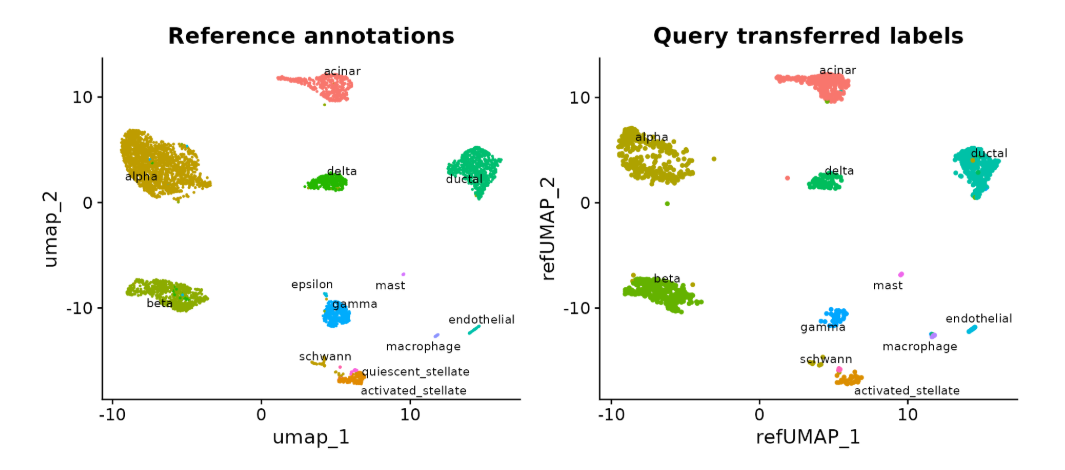

## **B: More on data integration**

*Layers in the Seurat v5 object*
Seurat v5 assays store data in layers. These layers can store raw, un-normalized counts (`layer='counts'`), normalized data (`layer='data'`), or z-scored/variance-stabilized data (`layer='scale.data'`).

When using Seurat v5 assays, we can instead keep all the data in one object, but simply join or split the layers. After splitting, there are now one layer per sample (a counts and data layer for each sample). We can also run a standard scRNA-seq analysis (i.e. without integration). Note that since the data is split into layers, normalization and variable feature identification is performed for each sample independently (a consensus set of variable features is automatically identified).

**1. Load objects and merge them into a only one seurat object.**

In [ ]:
naive.seu <- readRDS("P3/spleen.naive.clean.seu.Rds")
naive.seu
head(naive.seu@meta.data,2)
infected.seu <- readRDS("P3/spleen.infected.clean.seu.Rds")
infected.seu
head(infected.seu@meta.data,2)

`merge()` is a Seurat function (not from base R). It combines multiple Seurat objects into a single one by joining cells (columns) and taking the union of genes (rows) across assays. This is the standard way to bring together different samples before normalization or integration.

`add.cell.ids` prepends an identifier to each cell name before merging to ensure barcode uniqueness (since 10x barcodes often repeat across samples) and to encode the sample origin directly in the cell name, which is useful for quick inspection.

In [ ]:
#merge both seurat objects
seu <- merge(
  x = naive.seu, y = infected.seu,
  add.cell.ids = c("N1","I1"),
  project = "spleen_merged"
)

## Check
DefaultAssay(seu)         # "RNA"
Layers(seu[["RNA"]])      # should include "counts"
seu
head(seu@meta.data,2)
tail(seu@meta.data,2)

In [ ]:
#make sure is Seuratv5 format
cnt <- GetAssayData(seu, assay = "RNA", layer = "counts")
seuv5 <- CreateSeuratObject(counts = cnt, project = "v5_rebuild",
                             meta.data = seu@meta.data)

## Check
DefaultAssay(seuv5)         # "RNA"
Layers(seuv5[["RNA"]])      # should include "counts"
seuv5
head(seuv5@meta.data,2)
tail(seuv5@meta.data,2)

**2. Run standard analysis without integration**

Now we run a standard analysis without integration and visualize the results. Note that cells are grouping both by cell type and by sample/treatment. While a UMAP analysis is just a visualization of this, clustering this dataset returns predominantly batch-specific clusters. Especially if previous cell-type annotations were not available, this would make downstream analysis extremely challenging.

In [ ]:
#Split layers per sample (v5)
Layers(seuv5[["RNA"]])
seuv5[["RNA"]] <- split(seuv5[["RNA"]], f = seuv5$orig.ident)

In [ ]:
head(seuv5@meta.data,2)
seuv5

In [ ]:
seuv5 <- NormalizeData(seuv5)
seuv5 <- FindVariableFeatures(seuv5)
seuv5 <- ScaleData(seuv5)
seuv5 <- RunPCA(seuv5)
seuv5 <- FindNeighbors(seuv5, dims = 1:30, reduction = "pca")
seuv5 <- FindClusters(seuv5, resolution = 0.5, cluster.name = "unintegrated_clusters")
seuv5 <- RunUMAP(seuv5, dims = 1:30, reduction = "pca", reduction.name = "umap.unintegrated")


In [ ]:
seuv5

In [ ]:
# visualize by sample/treatment
options(repr.plot.width=16, repr.plot.height=9)
DimPlot(seuv5, reduction = "umap.unintegrated", group.by = c("unintegrated_clusters","treatment"))

**3. Perform streamlined (one-line) integrative analysis**

Seurat v5 enables streamlined integrative analysis using the `IntegrateLayers` function. The method currently supports five integration methods. Each of these methods performs integration in low-dimensional space, and returns a dimensional reduction (i.e. integrated.rpca) that aims to co-embed shared cell types across batches:

Anchor-based CCA integration (`method=CCAIntegration`)
Anchor-based RPCA integration (`method=RPCAIntegration`)
Harmony (`method=HarmonyIntegration`)
FastMNN (`method=FastMNNIntegration`)
scVI (`method=scVIIntegration`)
The anchor-based RPCA integration represents a faster and more conservative (less correction) method for integration. For interested users, this method is discussed in more detail in the RPCA [vignette](https://satijalab.org/seurat/articles/integration_rpca).

You can find more detail on each method, and any installation prerequisites, in Seurat’s documentation (for example, `?scVIIntegration`).

For CCA integration (as in the previous practical):

In [ ]:
seuv5 <- IntegrateLayers(
  object = seuv5, method = CCAIntegration,
  orig.reduction = "pca", new.reduction = "integrated.cca",
  verbose = FALSE
)

For Harmony integration:

In [ ]:
seuv5 <- IntegrateLayers(
  object = seuv5, method = HarmonyIntegration,
  orig.reduction = "pca", new.reduction = "harmony",
  verbose = FALSE
)

**4. Downstream analysis**

For any of the methods, we can now visualize and cluster the datasets. We show this for CCA integration and Harmony.

In [ ]:
##FOR CCA
seuv5 <- FindNeighbors(seuv5, reduction = "integrated.cca", dims = 1:30)
seuv5 <- FindClusters(seuv5, resolution = 0.5, cluster.name = "cca_clusters")
seuv5 <- RunUMAP(seuv5, reduction = "integrated.cca", dims = 1:30, reduction.name = "umap.cca")


In [ ]:
options(repr.plot.width=16, repr.plot.height=9)
DimPlot(seuv5, reduction = "umap.cca",
  group.by = c("treatment", "cca_clusters"),label.size = 2)

In [ ]:
##FOR Harmony
seuv5 <- FindNeighbors(seuv5, reduction = "harmony", dims = 1:30)
seuv5 <- FindClusters(seuv5, resolution = 0.5, cluster.name = "harmony_clusters")
seuv5 <- RunUMAP(seuv5, reduction = "harmony", dims = 1:30, reduction.name = "umap.harmnoy")

In [ ]:
head(seuv5@meta.data,2)

In [ ]:
options(repr.plot.width=16, repr.plot.height=9)
DimPlot(seuv5, reduction = "umap.harmnoy",
  group.by = c("treatment", "harmony_clusters"),label.size = 2)

 By simplifying the process of performing integrative analysis, users can more carefully evaluate the biological information retained in the integrated dataset. For example, users can compare the expression of biological markers based on different clustering solutions, or visualize one method’s clustering solution on different UMAP visualizations.



In [ ]:
p1 <- VlnPlot(
  seuv5,
  features = "Trem2", group.by = "unintegrated_clusters"
) + NoLegend() + ggtitle("TREM2 - Unintegrated Clusters")
p2 <- VlnPlot(
  seuv5, "Trem2",
  group.by = "cca_clusters"
) + NoLegend() + ggtitle("TREM2 - CCA Clusters")
p3 <- VlnPlot(
  seuv5, "Trem2",
  group.by = "harmony_clusters"
) + NoLegend() + ggtitle("TREM2 - Harmony Clusters")
p1 | p2 | p3